# 1. Import Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix, 
    precision_score, recall_score, f1_score
)
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 2. Load and Preprocess data

In [13]:
df = pd.read_csv('C:/Group_Project_ML2/dataset/creditcard.csv')
print(f"Dataset shape: {df.shape}")
print(f"Fraud cases: {df['Class'].sum()}")
print(f"Normal cases: {len(df) - df['Class'].sum()}")

df = df.sample(frac=1, random_state=42)

x = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
x['Amount'] = scaler.fit_transform(x[['Amount']])
x = x.drop(columns=['Time'])

Dataset shape: (284807, 31)
Fraud cases: 492
Normal cases: 284315


# 3. Prepare data for training and testing

In [14]:
x_normal = x[y == 0]
x_fraud = x[y == 1]

x_train = x_normal[:20000]
x_test = pd.concat([x_normal[20000:30000], x_fraud])
y_test = np.array([0] * 10000 + [1] * len(x_fraud))

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Training set size: 20000
Test set size: 10492


# 4. One-class SVM

In [15]:
print("\n" + "="*50)
print(" ONE-CLASS SVM ")
print("="*50)

svm = OneClassSVM(kernel='rbf', gamma=0.05, nu=0.01)
svm.fit(x_train)
y_pred_svm = svm.predict(x_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print(" One-Class SVM Results: ")
print(classification_report(y_test, y_pred_svm))
print(f"AUC: {roc_auc_score(y_test, y_pred_svm):.4f}")



 ONE-CLASS SVM 
 One-Class SVM Results: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10000
           1       0.48      0.87      0.62       492

    accuracy                           0.95     10492
   macro avg       0.74      0.91      0.80     10492
weighted avg       0.97      0.95      0.96     10492

AUC: 0.9136


# 5. Isolation Forest

In [16]:
print("\n" + "="*50)
print("ISOLATION FOREST ")
print("="*50)

iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(x_train)
y_pred_iso = iso.predict(x_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print(" Isolation Forest Results: ")
print(classification_report(y_test, y_pred_iso))
print(f"AUC: {roc_auc_score(y_test, y_pred_iso):.4f}")


ISOLATION FOREST 
 Isolation Forest Results: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10000
           1       0.72      0.57      0.63       492

    accuracy                           0.97     10492
   macro avg       0.85      0.78      0.81     10492
weighted avg       0.97      0.97      0.97     10492

AUC: 0.7772


# 6. Autoencoder

In [17]:
print("\n" + "="*50)
print(" AUTOENCODER ")
print("="*50)

input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, validation_split=0.1, 
                callbacks=[early_stop], verbose=1)

recon = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - recon, 2), axis=1)
threshold = np.percentile(mse, 99)
y_pred_auto = (mse > threshold).astype(int)

print(" Autoencoder Results: ")
print(classification_report(y_test, y_pred_auto))
print(f"AUC: {roc_auc_score(y_test, y_pred_auto):.4f}")



 AUTOENCODER 
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2091 - val_loss: 0.9946
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0456 - val_loss: 0.9110
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.8964 - val_loss: 0.8247
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8097 - val_loss: 0.7527
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7307 - val_loss: 0.6888
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6668 - val_loss: 0.6439
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6362 - val_loss: 0.6115
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6038 - val_loss: 0.5863
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5587 - val_loss: 0.5659
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5475 - val_loss: 0.5449
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
 Autoencoder Results: 
              precision    recall  f1-score   support

           0       0.

# 7. ROC Curves Comparison

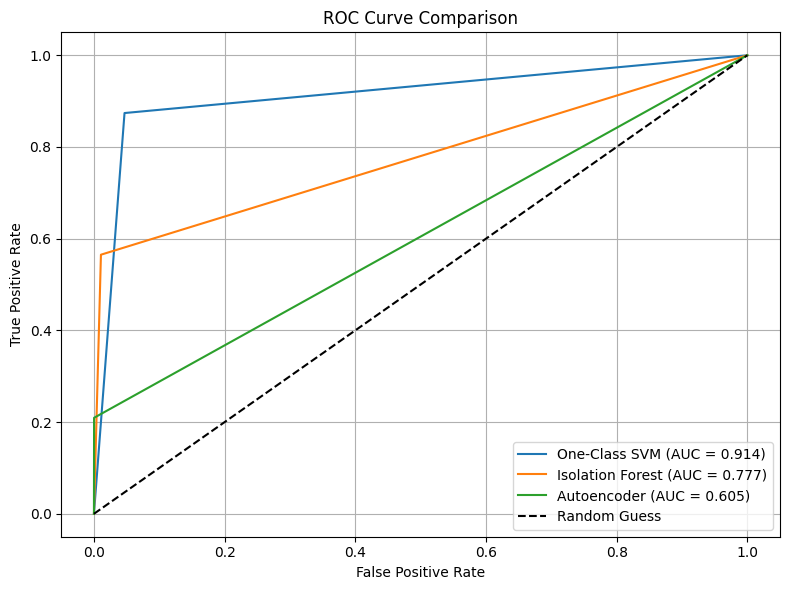

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_roc_curves(y_test, y_preds, labels):
    plt.figure(figsize=(8, 6))
    for y_pred, label in zip(y_preds, labels):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig("C:/Group_Project_ML2/visualizations/ROC_curves.png")

plot_roc_curves(y_test, [y_pred_svm, y_pred_iso, y_pred_auto], ["One-Class SVM", "Isolation Forest", "Autoencoder"])

# 8. Model Comparision Summary

In [19]:
print("\n" + "="*50)
print(" MODEL COMPARISON SUMMARY ")
print("="*50)

models_summary = {
    'Model': ['One-Class SVM', 'Isolation Forest', 'Autoencoder'],
    'AUC': [
        roc_auc_score(y_test, y_pred_svm),
        roc_auc_score(y_test, y_pred_iso),
        roc_auc_score(y_test, y_pred_auto)
    ],
    'Precision': [
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_iso),
        precision_score(y_test, y_pred_auto)
    ],
    'Recall': [
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_iso),
        recall_score(y_test, y_pred_auto)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_iso),
        f1_score(y_test, y_pred_auto)
    ]
}

summary_df = pd.DataFrame(models_summary)
print(summary_df.round(4))


 MODEL COMPARISON SUMMARY 
              Model     AUC  Precision  Recall  F1-Score
0     One-Class SVM  0.9136     0.4788  0.8740    0.6187
1  Isolation Forest  0.7772     0.7221  0.5650    0.6340
2       Autoencoder  0.6046     0.9810  0.2093    0.3451
